## Based on CRTS_sel_g_cut_vs_r_cut.ipynb,   taking only the code needed to make Fig. 2 

A testbed for making Fig.2 :  the 4-panel plot.  The 4-panel plot shows the problem :  how we can't get anything meaningful if we plot various characteristics of uncorrected data. Thus there is no reason to do splitting into magnitude bins, correcting, etc - it's not the purpose here. 

The desired magnitude range for the paper is 18.5-19 

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import CRTS_paper_modules as mod
reload(mod)

<module 'CRTS_paper_modules' from 'CRTS_paper_modules.pyc'>

In [3]:
cols1, qso_cat = mod.get_qso_catalog() 
cols2 , star_cat= mod.get_stars_catalog()

Zipping CRTS-SDSS quasars catalog from  ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...
Read in catalog for  48250 , stars from CRTS


In [1]:
Min = 18.5
Max = 19
magnitudes = ['r']  # don't need g magnitude , decided to use only r magnitude 

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
    report_mag = mag
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
    print('\n Reporting SDSS %s  '% report_mag)

    good_ids_S_blue = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                              gi_Max=1, cut_mag=cut_mag + '_mMed')
    
    good_ids_S_red = mod.cut_stars(star_cat = star_cat,mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                           gi_Max=3, cut_mag=cut_mag + '_mMed' )
    
    good_ids_QSO = mod.cut_qso(qso_cat=qso_cat, mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
                           'qso':good_ids_QSO}
    


Using now only lightcurves with SDSS  18.500000< r < 19.000000

 Reporting SDSS r  


NameError: name 'mod' is not defined

## Since I'm only using r_cut,   I won't compare it with g_cut .  Thus making r_bin is the same as r_cut  

In [12]:
bins = {}
bin_types = ['r_cut']  # removed 'g_cut'

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]

## Read the xi, ei for objects in the r_cut ... 

In [13]:
inDirStars   = '../data_products/sf_file_per_LC/stars/'
inDirQSO = '../data_products/sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print 'Reading in xi, ei for bin ', b
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB, starR = mod.read_xi_ei(inDirStars, good_ids_S_blue,  inDirQSO,
                                   good_ids_QSO, good_ids_S_red)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'starsR': starR, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 99% of qso 

----- Already read 99% of Blue Stars 

----- Already read 99% of Red Stars returning xi, ei for ... 747 objects


## 11)a)  Calculate SF, mu in approximate and  full  ways

In [17]:
# for all imports of my functions, 
# make python aware of my packages...
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import variabilityFunctions as varF


In [53]:
# Run the calculation over all bins : 
# - keep the option to plot a bin if one wants to compare the three methods : need to provide object N
#   
# - as it is, calculate three values for sigma, etc., and plot it  

# Set the bin  : here we use only r_cut 
b = 'r_cut'

# set the bin number 
nbins = 200 

# Set a directory to save the results...
outDir = os.path.join(os.getcwd()[:-4]+'data_products/'+'Fig_2_data/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
                      
print('Today we will save our Fig_2 files in %s'%outDir)

# Loop over objects in the dictionary  
for obj in ['starsR'] : # out_dic[b].keys()
    print '\n For obj = ', obj
    # obj = 'qso'  # or starsB,  starsR 
    m_ij = out_dic[b][obj][0]
    tau =  out_dic[b][obj][1]
    e_ij = out_dic[b][obj][2]

    #n =  out_dic[b][obj][3]

    # Pull out some tau to plot means : common to all panels 
    binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
    mean_tau = binned_tau[0]
    # Take N from each bin... 'count' function works like a regular histogram
    binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
    bin_count = binned_count[0]
    #bin_names = np.arange(1,len(binned_count[2]))

     # Calculate median preprocessed photometric error per bin 
    binned_err_median = binned_statistic(tau, e_ij, statistic='median', bins=nbins) 
    err_median = binned_err_median[0]

    # checking for empty bins : either mean or some custom function, but not
    # count! If statistic='count', then check for 0's , and not for nan's/ 
    non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

    # reassign number of points in a bin and  tau position 

    bin_count = bin_count[non_empty_bins]
    mean_tau = mean_tau[non_empty_bins]
    err_median = err_median[non_empty_bins]

    # Which point belongs to which bin
    bin_number  = binned_tau[2]
    
    ####
    ####  Panel 1 : Standard Deviation 
    ####

    rms_std = lambda x : np.std(x)
    stdev_binned = binned_statistic(tau, m_ij, statistic = rms_std, 
                                              bins=nbins)


    bin_stdev = stdev_binned[0][non_empty_bins]  
    #bin_number = stdev_binned[2]  
     # since each point belongs to some bin : len(bin_number) =len(delflx)


    # error on standard deviation in the bin     
    # calculate when plotting, since it's just a function of bin count... 
    
    #err_stdev = bin_stdev / np.sqrt(2.0*(bin_count - 1.0))

    #####
    ##### Panel 2  : Gaussian rms  
    #####
    rms_robust = lambda x : 0.7414 *(np.percentile(x,75) - np.percentile(x,25))
    bin_sigma_G = binned_statistic(tau, m_ij, statistic = rms_robust, 
                                      bins=nbins)[0][non_empty_bins]

    #####
    ##### Panel 3 (SF)   and Panel 4   (mu)
    #####


    # Loop over all bins  calculating approximate mu and sigma 

    mu_bins = {}
    sig_bins = {}

    sig_bins['approx'] = np.zeros(nbins)
    mu_bins['approx'] = np.zeros(nbins)
    sig_bins['full'] = np.zeros(nbins)
    mu_bins['full'] = np.zeros(nbins)
    
    for N in np.unique(bin_number):
        print('\r --- Calculating mu, sigma for bin %d' % N),
        xi = m_ij[bin_number == N]
        ei = e_ij[bin_number == N]

        # 1) Calculate in an approximate way 
        mu_approx, sig_approx = varF.approximate_mu_sigma(xi, ei)
        mu_full, sig_full =  varF.get_mu_sigma(xi,ei)
        
        sig_bins['approx'][N-1] = sig_approx
        sig_bins['full'][N-1] = sig_full
        
        mu_bins['approx'][N-1] = mu_approx
        mu_bins['full'][N-1] = mu_full 


    # Save the results of calculation  : Panel 1,2,3,4 

    fname = outDir+ b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    

    data = np.column_stack((mean_tau, bin_stdev, bin_sigma_G, sig_bins['full'], 
                            sig_bins['approx'], mu_bins['full'], mu_bins['approx'], bin_count))

    header = 'meanTau   stdev    sigmaG   sigmaFull  sigmaApprox   muFull  muApprox   binCount'
    np.savetxt(fname, data, fmt = '%s', delimiter = ' ' , header=header )
    print 'Results saved as ', fname

print 'Done with calculating panel data '    

 Today we will save our Fig_2 files in /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/

 For obj =  starsR
 --- Calculating mu, sigma for bin 200 
 In this calculation, fc= 1.0
Results saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/r_cut_18.5-19_starsR_fc-1.0.txt
Done with calculating panel data 


## Read in the calculation results 

If the calculation for each bin has already been done, and only some fine tuning is needed for the figure, you can set the Min, Max mags for the cut below, and we will read in the results from the files and plot it all. 

In [8]:
import numpy as np 

from collections import OrderedDict
plot_data = OrderedDict()


Min = 18.5
Max = 19

#outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_2_data', 
#                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')

outDir = '/local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/'
for obj in ['qso', 'starsB', 'starsR']:
    plot_data[obj] = {}

    fname = outDir+ 'r_cut_'+str(Min)+'-'+str(Max)+'_'+obj+'.txt'
    print 'Reading from', fname

    colnames = open(fname,'r').read().splitlines()[0][1:].split()
    d = np.genfromtxt(fname, dtype=float)

    for label, column in zip(colnames, d.T):
        plot_data[obj][label] = column


Reading from /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/r_cut_18.5-19_qso.txt
Reading from /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/r_cut_18.5-19_starsB.txt
Reading from /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/r_cut_18.5-19_starsR.txt


## Make Fig.2 : four-panel plot (can run only cells below to make  Fig.2) 

Note: now since we are convinced that the full results are better than the approximate ones, we plot only muFull and sigmaFull. But muApprox and sigmaApprox is still there... 

In [3]:
import matplotlib 
from matplotlib import rcParams
matplotlib.rcParams['font.size'] = 17

Figure is saved as  /local/tmp/suberlak/CRTS_PROJECT/data_products/Fig_2_data/2016-06-03/Fig_2_18.5-19_panels.png


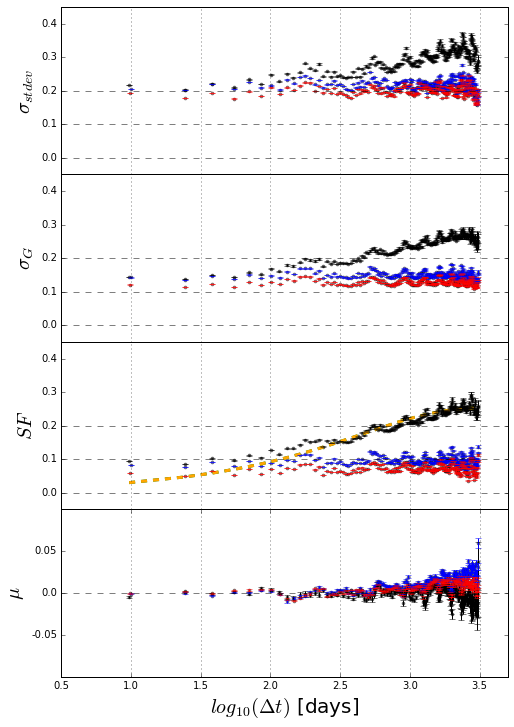

In [9]:
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
%matplotlib inline
# set all plot parameters
lh_w   = 1.0  # horizontal line thickness 
lh_st  = '--' # horizontal line style 
lh_al  = 0.5  # horizontal line alpha parameter 

# dot size 
p_size = 7
p_al   = 0.5 

# y limits for sigma, sigma_G, SF panels 
y_top  = 0.45
y_bott = -0.05

# y limits for mu approx 
y_mu_top = 0.1
y_mu_bott = -0.1

# x limits for ALL PANELS 
x_left = 0.5
x_right = 3.7

# colors for quasars, blue and red stars 
colors= {}
colors['qso'] = 'black'
colors['starsB'] = 'blue'
colors['starsR']   = 'red'

fig,ax = plt.subplots(4,1, figsize=(8,12), sharex=True)
fig.subplots_adjust(hspace=0)

# Panel 1 
for obj in plot_data.keys() : 
    ax[0].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errStdev = plot_data[obj]['stdev'] / np.sqrt(2.0*(plot_data[obj]['binCount'] - 1.0))
    ax[0].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['stdev'],errStdev, 
                   linestyle='None', c = colors[obj]  )

ax[0].set_ylabel(r'$\sigma_{stdev}$',fontsize=20)  
ax[0].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[0].set_ylim(bottom=y_bott, top=y_top)
ax[0].set_xlim(left=x_left, right=x_right)
ax[0].set_yticks([0,0.1,0.2,0.3,0.4])
ax[0].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[0].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[0].grid(axis='x')



# Panel 2
for obj in plot_data.keys() : 
    ax[1].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    errSigmaG = plot_data[obj]['sigmaG']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    ax[1].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaG'],errSigmaG, 
                   linestyle='None', c = colors[obj] )


ax[1].set_ylabel(r'$\sigma_{G}$',fontsize=20)  
ax[1].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off') 
ax[1].set_ylim(bottom=y_bott, top=y_top)
ax[1].set_xlim(left=x_left, right=x_right)
ax[1].set_yticks([0,0.1,0.2,0.3,0.4])
ax[1].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[1].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[1].grid(axis='x')




    # mu_bins['approx_err'] = bin_stdev / np.sqrt(bin_count)


# Panel 3
 
def model_sf(t, sf_inf=0.25, tau = 1.0):
    br = 1.0-np.exp(-t/tau)
    sf = sf_inf * np.power(br,0.5)
    return sf

# Calculate the model DRW fit for QSO
obj = 'qso'
xdata = plot_data[obj]['meanTau']
sf = plot_data[obj]['sigmaFull']
popt, pcov = curve_fit(model_sf, xdata, sf)
y = model_sf(xdata, sf_inf=popt[0], tau = popt[1]) # tau 1 year in days 

# Fold-in the error to the model SF , plot 
# both folded and not-folded version 

err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
y_fold = np.sqrt((y ** 2.0)+ (err_sig ** 2.0) )
ax[2].plot(np.log10(xdata), y_fold , lw=3, c = 'green', ls='--')
ax[2].plot(np.log10(xdata), y , lw=3, c = 'orange', ls='--')

#text = r'$ \mathrm{Model:}\ \tau=%.3f \,\mathrm{days} , \ SF_{\infty}=%.3f \,\mathrm{mag}$'%(popt[1],popt[0])
#ax[2].text(x=0.75, y=0.3,s = text )


# plot approximate sigma 
for obj in plot_data.keys() : 
    
    ax[2].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_sig = plot_data[obj]['sigmaFull']* 1.06 / np.sqrt(plot_data[obj]['binCount'])
    # 
    ax[2].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['sigmaFull'],err_sig, 
                   linestyle='None', c = colors[obj]  )
    
    
ax[2].set_ylim(bottom=y_bott, top=y_top)
ax[2].set_xlim(left=x_left, right=x_right)
ax[2].set_ylabel(r'$SF $',fontsize=20)
ax[2].tick_params( axis='x', which='both',  bottom='off', 
                top='off', labelbottom='off')
ax[2].grid(axis='x')
ax[2].set_yticks([0,0.1,0.2,0.3,0.4])
ax[2].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
ax[2].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)    
ax[2].axhline(y=0.1, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[2].axhline(y=0.2, color='black', lw=lh_w, ls=lh_st,alpha=lh_al) 

# Panel 4 
for obj in plot_data.keys() : 
    ax[3].scatter(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'], s=p_size, 
                    alpha=p_al, c = colors[obj])
    err_mu =  plot_data[obj]['stdev'] / np.sqrt(plot_data[obj]['binCount'])
    ax[3].errorbar(np.log10(plot_data[obj]['meanTau']), plot_data[obj]['muFull'],err_mu, 
                   linestyle='None', c = colors[obj]  )
    
ax[3].axhline(y=0.0, color='black', lw=lh_w, ls=lh_st,alpha=lh_al)
ax[3].set_ylim(top=y_mu_top, bottom=y_mu_bott)
ax[3].set_xlim(left=x_left, right=x_right)
ax[3].set_yticks([-0.05,0,0.05])
ax[3].set_yticklabels(['-0.05','0.0', '0.05'])  
ax[3].set_ylabel(r'$\mu$', fontsize=20)
ax[3].grid(axis='x')
ax[3].set_xlabel(r'$log_{10} (\Delta t)$ [days]',fontsize=20)

figname = outDir+'Fig_2_'+str(Min)+'-'+str(Max)+'_panels.png'
plt.savefig(figname)
print 'Figure is saved as ', figname 

# 

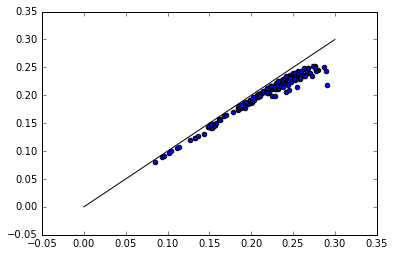

In [57]:
#Show that indeed full vs approximate are slightly different, but not too much..
plt.scatter(plot_data['qso']['sigmaFull'], plot_data['qso']['sigmaApprox'])
plt.plot(np.linspace(0,0.3),np.linspace(0,0.3), color='black')